In [0]:
"""
Functions to be used 
"""
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from google.colab import files

def power_law(x,A, D):
    '''
    Power law function needed for fitting
    '''
    return A*np.power(x, D)

def linear(x, m, c):
    '''
    Linear function needed for fitting
    '''
    return m*x + c

def p_inf(k,m):
    '''
    p_inf for preferential attachment
    '''
    return (2*m*(m+1))/(k*(k+1)*(k+2))

def exp_k(x, A, B, E):
    return A*B**(E*x)

def k1_prf(N, m):
    '''
    k1 in preferential attachment
    '''
    num = -1 + np.sqrt(1+4*m*N*(m+1))
    return num / 2

def pure(k, m):
    '''
    p_inf pure random attachment
    '''
    return m**(k-m)/((1+m)**(k-m+1))

def k1_rnd(N, m):
    '''
    k1 in random attachment
    '''
    return m - (np.log(N) / (np.log(m) - np.log(m+1)))

def report(A):
        '''
        The number of edges and vertices in adjacency list
        '''
        s = 0
        for i in range(len(A)): 
             s += len(A[i])  
        edges_num = s // 2
        vertex_num = len(A)
        print('The number of edges is', edges_num)
        print('The number of vertices is', vertex_num)
        return edges_num, vertex_num
# logbin code given

def logbin(data, scale = 1., zeros = False):
    """
    
    logbin(data, scale = 1., zeros = False)

    Log-bin frequency of unique integer values in data. Returns probabilities
    for each bin.

    Array, data, is a 1-d array containing full set of event sizes for a
    given process in no particular order. For instance, in the Oslo Model
    the array may contain the avalanche size recorded at each time step. For
    a complex network, the array may contain the degree of each node in the
    network. The logbin function finds the frequency of each unique value in
    the data array. The function then bins these frequencies in logarithmically
    increasing bin sizes controlled by the scale parameter.

    Minimum binsize is always 1. Bin edges are lowered to nearest integer. Bins
    are always unique, i.e. two different float bin edges corresponding to the
    same integer interval will not be included twice. Note, rounding to integer
    values results in noise at small event sizes.

    Parameters
    ----------

    data: array_like, 1 dimensional, non-negative integers
          Input array. (e.g. Raw avalanche size data in Oslo model.)

    scale: float, greater or equal to 1.
          Scale parameter controlling the growth of bin sizes.
          If scale = 1., function will return frequency of each unique integer
          value in data with no binning.

    zeros: boolean
          Set zeros = True if you want binning function to consider events of
          size 0.
          Note that output cannot be plotted on log-log scale if data contains
          zeros. If zeros = False, events of size 0 will be removed from data.

    Returns
    -------

    x: array_like, 1 dimensional
          Array of coordinates for bin centres calculated using geometric mean
          of bin edges. Bins with a count of 0 will not be returned.
    y: array_like, 1 dimensional
          Array of normalised frequency counts within each bin. Bins with a
          count of 0 will not be returned.
    """
    import numpy as np
    if scale < 1:
        raise ValueError('Function requires scale >= 1.')
    count = np.bincount(data)
    tot = np.sum(count)
    smax = np.max(data)
    if scale > 1:
        jmax = np.ceil(np.log(smax)/np.log(scale))
        if zeros:
            binedges = scale ** np.arange(jmax + 1)
            binedges[0] = 0
        else:
            binedges = scale ** np.arange(1,jmax + 1)
            # count = count[1:]
        binedges = np.unique(binedges.astype('uint64'))
        x = (binedges[:-1] * (binedges[1:]-1)) ** 0.5
        y = np.zeros_like(x)
        count = count.astype('float')
        for i in range(len(y)):
            y[i] = np.sum(count[binedges[i]:binedges[i+1]]/(binedges[i+1] - binedges[i]))
            # print(binedges[i],binedges[i+1])
        # print(smax,jmax,binedges,x)
        # print(x,y)
    else:
        x = np.nonzero(count)[0]
        y = count[count != 0].astype('float')
        if zeros != True and x[0] == 0:
            x = x[1:]
            y = y[1:]
    y /= tot
    x = x[y!=0]
    y = y[y!=0]
    return x,y

def degree(A):
  '''
  Returns the degree sequence for a given adjacency list, A. 
  '''
  return [len(i) for i in A]


# Preferential Attachment

In [0]:
'''
Analysis for Networks
'''
# for preferential attachment

with open('/content/drive/My Drive/Year 3/networks_data.pkl', 'rb') as f:
    data = pickle.load(f)

m_list = data[0] 
N_list_seed = data[1] 

m = [1, 5, 10, 20]
N = [100, 1000, 10000, 100000, 1000000]

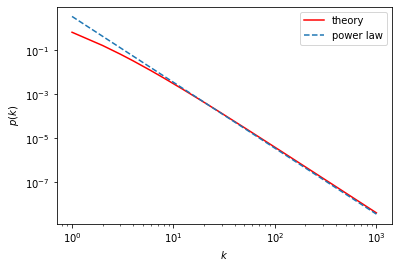

In [0]:
# theoretical checks

# plotting the probability equation
k_range = np.linspace(1, 1000, 1000)
p_k = [p_inf(i, m = 1) for i in k_range]
f = plt.figure()
plt.loglog(k_range, p_k, '-', ms = '1.0', color = 'r', label = 'theory')
plt.loglog(k_range, power_law(k_range, 3.5, -3), '--', label = 'power law')
plt.ylabel("$p(k)$")
plt.xlabel("$k$")
plt.legend()
plt.show() 

f.savefig('theory_check.pdf')
files.download('theory_check.pdf') 

1.3159271189918522 -2.640511980816082
36.97043770905459 -2.887132607914791
147.05116998835163 -2.9102245450785484
711.766078090038 -2.969680181341655


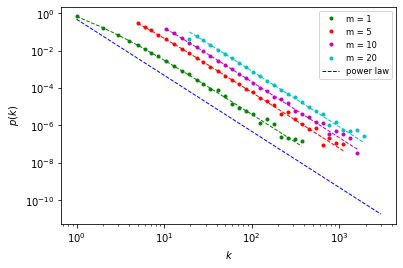

In [0]:
# plotting m_list
x_plot = np.linspace(1, 3000)
coeff_m = []
power_m = []
col = ['g', 'r', 'm', 'c']
f1 = plt.figure()

for j in range(len(m_list)):
    degree_seq_m = degree(m_list[j])
    x, y = logbin(degree_seq_m, scale = 1.2)
    (A, B), cov = curve_fit(power_law, x[5:], y[5:])
    coeff_m.append(A)
    power_m.append(B)
    print(A, B)
    plt.loglog(x, y, '.', color = col[j], label = 'm = %r' %(m[j]))
    plt.loglog(x, p_inf(x, m[j]), '--', color = col[j], linewidth = 1.0)

plt.loglog(x_plot, power_law(x_plot, A/1500, -3), '--b', label = 'power law', linewidth = 1.0)    
plt.legend(fontsize = 'small')
#plt.title("Degree distribution for different m")
plt.ylabel("$p(k)$")
plt.xlabel("$k$")
plt.show()  

f1.savefig('1.pdf')
files.download('1.pdf') 

In [0]:
# statistics for varying m -  using precise eq

for j in range(len(m_list)):
  degree_seq_m = degree(m_list[j])
  x, y = logbin(degree_seq_m, scale = 1.2)
  print(len(x))
  stat, p_value = chisquare(y, p_inf(x, m[j]))  # okay for binned data
  print(stat, p_value)


28
7.395102587341006e-05 1.0
30
4.9284122872991564e-05 1.0
28
5.164264675756344e-05 1.0
26
0.03178579972943072 1.0


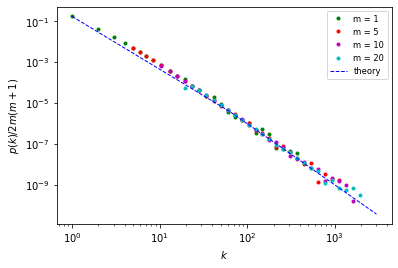

In [0]:
# for possible data collapse for m from precise p_inf
f2 = plt.figure()
for j in range(len(m_list)):
  degree_seq_m = degree(m_list[j])
  x, y = logbin(degree_seq_m, scale = 1.2)
  y_r = [i/(2*m[j]*(m[j]+1)) for i in y]
  plt.loglog(x, y_r, '.',color = col[j], label = 'm = %r' %(m[j]))

plt.loglog(x_plot, 1/(x_plot*(x_plot+1)*(x_plot+2)) , '--b', label = 'theory', linewidth = 1.0)
plt.legend(fontsize = 'small')
#plt.title("Data collapse for different m")
plt.ylabel("$p(k)/ 2m(m+1)$")
plt.xlabel("$k$")
plt.show()

f2.savefig('2.pdf')
files.download('2.pdf') 

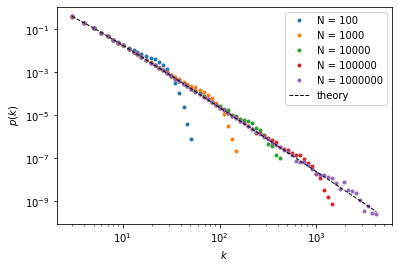

In [0]:
# plotting N_list

k1_mean = []
k1_std = []
f3 = plt.figure()
for j in range(len(N_list_seed)):
    degree_N = []
    k1 = []
    for i in N_list_seed[j]:
        deg = degree(i)
        degree_N.append(deg)
        k1.append(max(deg))
    
    degree_N = np.concatenate(degree_N)
    k1_mean.append(np.mean(k1))
    k1_std.append(np.std(k1))
    x, y = logbin(degree_N, scale = 1.1)
    plt.loglog(x, y, '.', label = 'N = %r' %N[j])
#    if N[j] > 1000:
#      (A, B), cov = curve_fit(power_law, x[10:], y[10:])
#      print(A,B)
    
plt.loglog(x, p_inf(x, 3),'--', color = 'black', label = 'theory', linewidth = 1.0)
plt.legend()
#plt.title("Degree distribution for different N")
plt.ylabel("$p(k)$")
plt.xlabel("$k$")
plt.show()

f3.savefig('3.pdf')
files.download('3.pdf') 

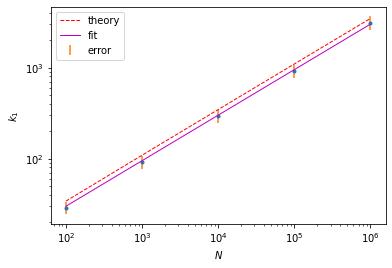

In [0]:
# largest degree k1
f4 = plt.figure()

plt.plot(N, k1_mean,'.')
plt.errorbar(N, k1_mean, yerr = k1_std, fmt = 'none', label ='error')
y_k_prf = [k1_prf(i, m = 3) for i in N]
plt.loglog(N, y_k_prf, '--', color = 'r', label = 'theory', linewidth = 1.0)
plt.loglog(N, power_law(N, 3, 0.50), '-', color = 'm', label = 'fit', linewidth = 1.0)
plt.legend()
#plt.title("Largest Degree")
plt.ylabel("$k_1$")
plt.xlabel("$N$")
plt.show()

f4.savefig('4.pdf')
files.download('4.pdf') 

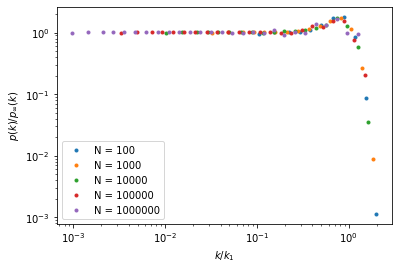

In [0]:
# data collapse on N
f5 = plt.figure()
for j in range(len(N_list_seed)):
    degree_N = []
    for i in N_list_seed[j]:
        deg = degree(i)
        degree_N.append(deg)
    
    degree_N = np.concatenate(degree_N)
    x, y = logbin(degree_N, scale = 1.3)
    x_r = [i/k1_mean[j] for i in x]
    y_p = [1/i for i in p_inf(x, m =3)]
    y_r = np.multiply(y, y_p)
    plt.loglog(x_r, y_r, '.', label = 'N = %r' %N[j])

plt.legend()
#plt.title("Data collapse for different N")
plt.ylabel("$p(k)/p_{\infty}(k)$")
plt.xlabel("$k/k_1$")
plt.show()

f5.savefig('5.pdf')
files.download('5.pdf') 

# Pure Random Attachment


In [0]:
# for random attachment
with open('/content/drive/My Drive/Year 3/networks_data_rnd.pkl', 'rb') as f:
    data_2 = pickle.load(f)

m_list_2 = data_2[0] 
N_list_seed_2 = data_2[1]     
    
m = [1, 5, 10, 20]
N = [100, 1000, 10000, 100000, 1000000]


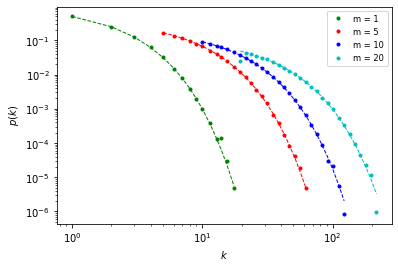

In [0]:
# pure random attachment

# plotting m_list
f6 = plt.figure()
coeff_m_2 = []
power_m_2 = []
const_m_2 = []
col = ['g', 'r', 'b', 'c']
for j in range(len(m_list_2)):
    degree_seq_m_2 = degree(m_list_2[j])
    x_2, y_2 = logbin(degree_seq_m_2, scale = 1.1)
    plt.loglog(x_2, y_2, '.', color = col[j], label = 'm = %r' %(m[j]))
    plt.loglog(x_2, pure(x_2, m = m[j]), '--', color = col[j], linewidth = 1.0)

plt.legend(fontsize = 'small')
#plt.title("Degree distribution for different m for random attachment")
plt.ylabel("$p(k)$")
plt.xlabel("$k$")
plt.show()  

f6.savefig('6.pdf')
files.download('6.pdf') 

In [0]:
# random attachment
# statistics for varying m -  printing chisquare and p values 

for j in range(len(m_list_2)):
  degree_seq_m = degree(m_list_2[j])
  x, y = logbin(degree_seq_m, scale = 1.1)
  stat, p_value = chisquare(y, pure(x, m[j]))    
  print(stat, p_value)


0.00016956473485918975 1.0
7.095115110255581e-05 1.0
6.017980116416502e-05 1.0
0.012528858297609647 1.0


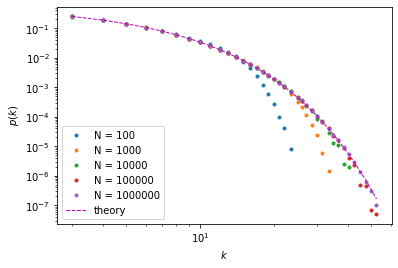

In [0]:
# Random attachment
# plotting N_list
# m fixed at 3
f7 = plt.figure()
k1_mean = []
k1_std = []
for j in range(len(N_list_seed_2)):
    degree_N = []
    k1 = []
    for i in N_list_seed_2[j]:
        deg = degree(i)
        degree_N.append(deg)
        k1.append(max(deg))
    
    degree_N = np.concatenate(degree_N)
    k1_mean.append(np.mean(k1))
    k1_std.append(np.std(k1))
    x, y = logbin(degree_N, scale = 1.05)
    plt.loglog(x, y, '.', label = 'N = %r' %N[j])
    
plt.loglog(x, pure(x, m= 3),'--', color = 'm', label = 'theory', linewidth = 1.0)
plt.legend()
#plt.title("Degree distribution for different N for random attachment")
plt.ylabel("$p(k)$")
plt.xlabel("$k$")
plt.show()

f7.savefig('7.pdf')
files.download('7.pdf') 

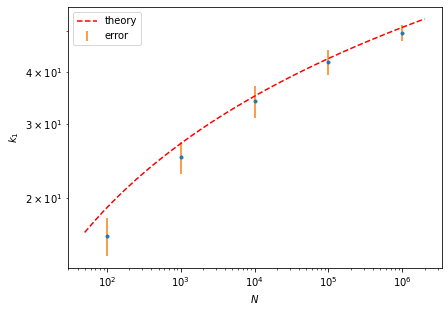

Largest k1 is 49.5
0.6214387133752071 0.9606518226978624


In [0]:
# largest degree k1  - random attachment
f8 = plt.figure(figsize=[6.7, 4.8])
N_range = np.linspace(50, 2e6, 100000)
plt.loglog(N, k1_mean,'.')
plt.errorbar(N, k1_mean, yerr = k1_std, fmt = 'none', label ='error')
# (C, D), kcov2 = curve_fit(k1, N, k1_mean)
# error_k1_2 = np.sqrt(np.diag(kcov2))
# print(C, D)
# print(error_k1_2)
plt.loglog(N_range, k1_rnd(N_range, m = 3),'--', color = 'r', label = 'theory')
plt.legend()
#plt.title("Largest Degree")
plt.ylabel("$k_1$")

plt.xlabel("$N$")
plt.show()

f8.savefig('8.pdf')
files.download('8.pdf') 

# largest k1 in the simulation
print('Largest k1 is', k1_mean[-1])

# the statistics
y_k = [k1_rnd(i, m = 3) for i in N]
stat, p_value = chisquare(k1_mean, y_k)    
print(stat, p_value)

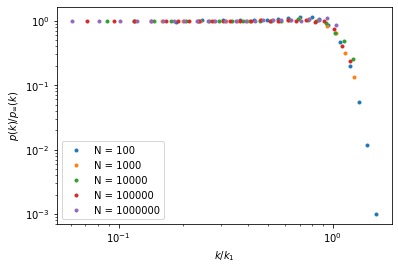

In [0]:
# data collapse on N

for j in range(len(N_list_seed_2)):
    degree_N = []
    for i in N_list_seed_2[j]:
        deg = degree(i)
        degree_N.append(deg)
    
    degree_N = np.concatenate(degree_N)
    x, y = logbin(degree_N, scale = 1.1)
    x_r = [i/k1_mean[j] for i in x]
    y_p = [1/i for i in pure(x, m =3)]
    y_r = np.multiply(y, y_p)
    plt.loglog(x_r, y_r, '.', label = 'N = %r' %N[j])

plt.legend()
#plt.title("Data collapse for different N")
plt.ylabel("$p(k)/p_{\infty}(k)$")
plt.xlabel("$k/k_1$")
plt.show()